In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

# Loading data from NPZ files 
---

Two steps here: load the NPZ files then subset the arrays. We end up with two arrays. x=images, y=labels

In [2]:
!ls -1 ../input

__output__.json
__results__.html
__results___files
custom.css
x_images_arrays.npz
y_infiltration_labels.npz


In [3]:
# Load npz file containing image arrays
x_npz = np.load("../input/x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("../input/y_infiltration_labels.npz")
y = y_npz['arr_0']

# Split into training, validation, and test sets (80/10/10)
---

First, I split the arrays into 80% for training data and 20% for validaiton and test sets. The second line splits the 20% into the validation and test sets giving us an 80/10/10 split for training, validation, and testing.

In [4]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [5]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(4484, 128, 128, 3)
(561, 128, 128, 3)
(561, 128, 128, 3)


# Setting up the model in Keras
---

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
K.image_data_format()

'channels_last'

In [8]:
img_width, img_height = 128, 128
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.Dense(1))
model.add(layers.BatchNormalization())
model.add(layers.Activation("sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 64)        0         
__________

# Data augmentation
---

I'm rescaling the values by 1/255<br>
Randomly flipping images horizontally<br>
Randomly rotating in a range of 30 degrees<br>

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [11]:
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = val_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

In [12]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

model.save_weights('weights.h5')

Epoch 1/10
280/280 [==============================] - 300s 1s/step - loss: 0.6919 - acc: 0.6123 - val_loss: 1.0097 - val_acc: 0.2482
Epoch 2/10
280/280 [==============================] - 298s 1s/step - loss: 0.6010 - acc: 0.6837 - val_loss: 0.6195 - val_acc: 0.6911
Epoch 3/10
280/280 [==============================] - 300s 1s/step - loss: 0.5395 - acc: 0.7621 - val_loss: 0.5606 - val_acc: 0.7696
Epoch 4/10
280/280 [==============================] - 302s 1s/step - loss: 0.5005 - acc: 0.8085 - val_loss: 0.5268 - val_acc: 0.8107
Epoch 5/10
280/280 [==============================] - 305s 1s/step - loss: 0.4790 - acc: 0.8190 - val_loss: 0.4851 - val_acc: 0.8250
Epoch 6/10
280/280 [==============================] - 303s 1s/step - loss: 0.4638 - acc: 0.8261 - val_loss: 0.4612 - val_acc: 0.8250
Epoch 7/10
280/280 [==============================] - 305s 1s/step - loss: 0.4542 - acc: 0.8281 - val_loss: 0.4610 - val_acc: 0.8268
Epoch 8/10
280/280 [==============================] - 304s 1s/step - 

# Visualize the results on the training and validation data
---

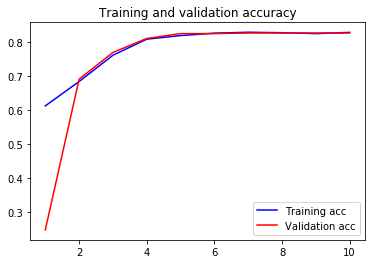

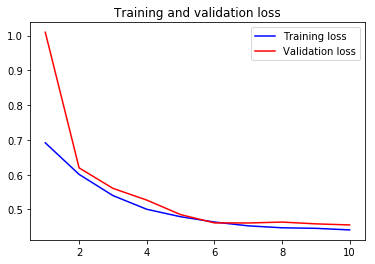

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()